In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 16,
    })

from fiesta.filters import Filter

In [59]:
with h5py.File("./Bu2024_raw_data_unprocessed.h5") as f:
     
     nus = f["nus"][:]
     times = f["times"][:]
     log_flux = f["test"]["y"][-4].reshape(*nus.shape, *times.shape) # interesting 120
     X = f["test"]["X"][:]


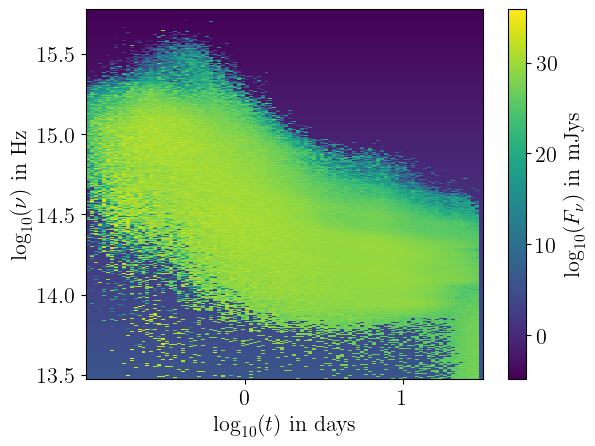

In [60]:
plt.pcolormesh(np.log10(times), np.log10(nus), log_flux)
plt.xlabel("$\log_{10}(t)$ in days")
plt.ylabel("$\log_{10}(\\nu)$ in Hz")
plt.colorbar(label="$\\log_{10}(F_{\\nu})$ in mJys")

In [61]:
nus[120]/1e14

0.5650247980549632

/tmp/ipykernel_10949/1704801274.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


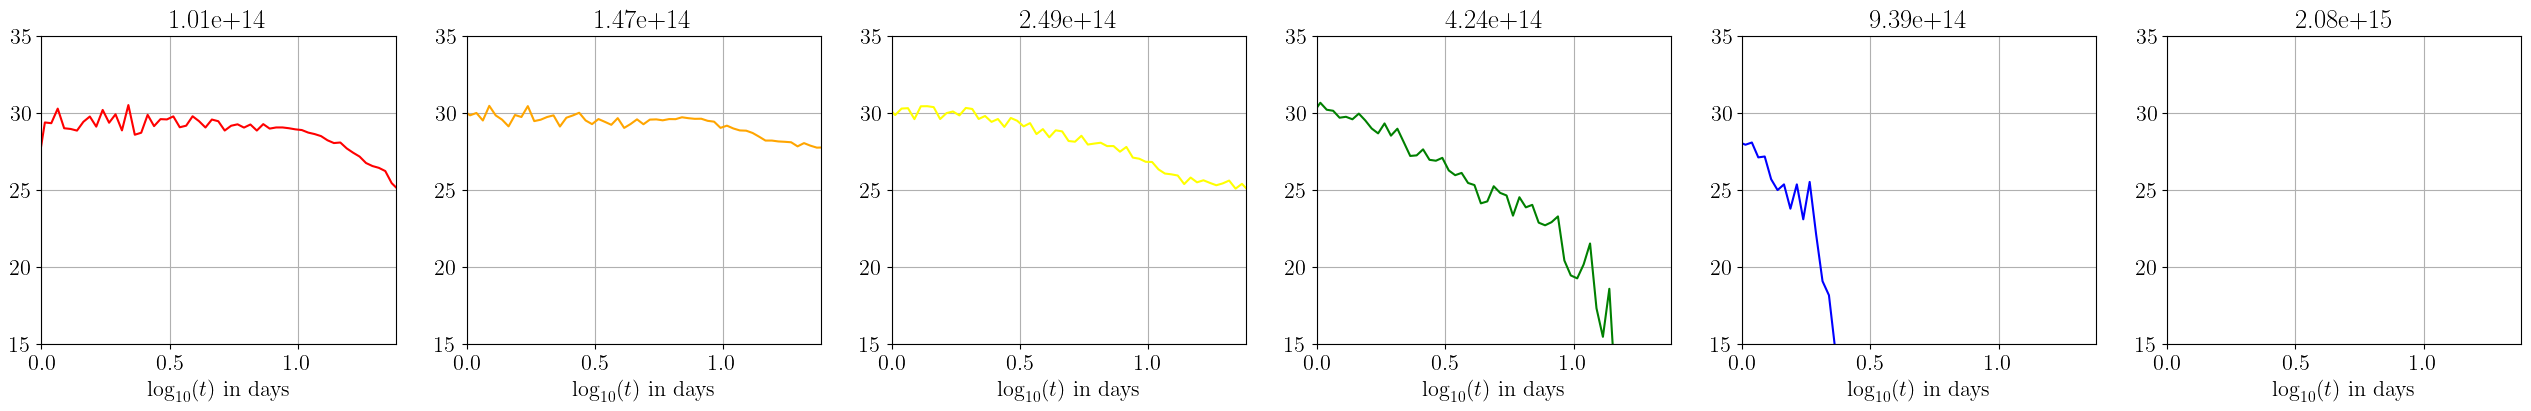

In [62]:
fig, ax = plt.subplots(1,6, figsize = (32,4))

for cax, ind, color in zip(ax, [230, 300, 400, 500, 650, 800], ["red", "orange", "yellow", "green", "blue", "purple"]):
    cax.plot(np.log10(times), log_flux[ind], color=color)
    cax.set_xlabel("$\\log_{10}(t)$ in days")
    cax.set_title(f"{nus[ind]:.2e}")
    cax.set_ylim(15, 35)
    cax.set_xlim(0, np.log10(24))
    cax.grid(True)

fig.show()

In [50]:
from fiesta.conversions import mJys_to_mag_jnp, mag_app_from_mag_abs

mag_app_from_mag_abs(mJys_to_mag_jnp(np.exp(15)), 1e1)

Array(30.113958, dtype=float32)

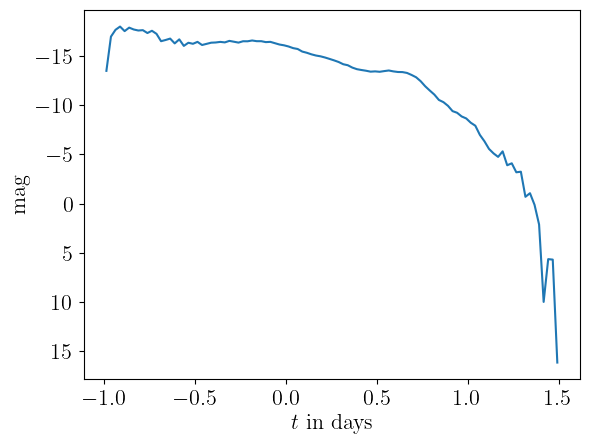

In [57]:
filt = Filter("ps1::r")

mag = filt.get_mag(np.exp(log_flux), nus)

plt.plot(np.log10(times), mag)
plt.xlabel("$t$ in days")
plt.ylabel("mag")
plt.gca().invert_yaxis()

In [59]:
pad_width = 20
log_flux_arg = np.pad(log_flux, pad_width=((pad_width, pad_width), (0,0)), mode="edge")

fft_log_flux = np.fft.fftshift(np.fft.fft2(log_flux_arg))

fft_log_flux[:pad_width+400] = 0
fft_log_flux[-400-pad_width:] = 0
fft_log_flux[:, :20] = 0
fft_log_flux[:, -20:] = 0

fft_log_flux[np.abs(fft_log_flux)<4e3] = 0

reconstructed_log_flux = np.fft.ifft2(np.fft.ifftshift(fft_log_flux))
reconstructed_log_flux = reconstructed_log_flux[pad_width:-pad_width, :]


/tmp/ipykernel_23730/1719149816.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(np.log10(np.abs(fft_log_flux) ) )


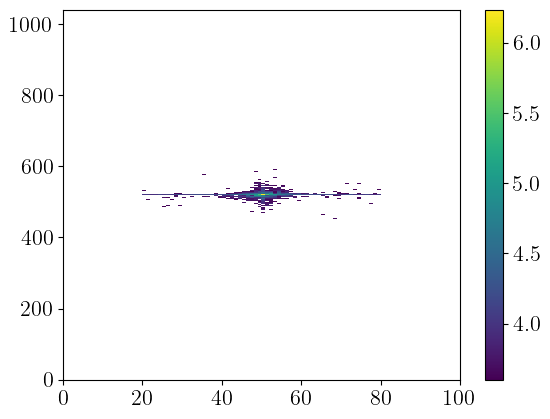

In [60]:
plt.pcolormesh(np.log10(np.abs(fft_log_flux) ) )

plt.colorbar()
plt.show()

In [61]:
reconstructed_log_flux = fourier_transform(log_flux)

plt.pcolormesh(np.log10(times), np.log10(nus), reconstructed_log_flux)

plt.colorbar()

NameError: name 'fourier_transform' is not defined

/home/enlil/hkoehn/miniconda3/envs/fiesta/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/enlil/hkoehn/miniconda3/envs/fiesta/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_23730/2395240069.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


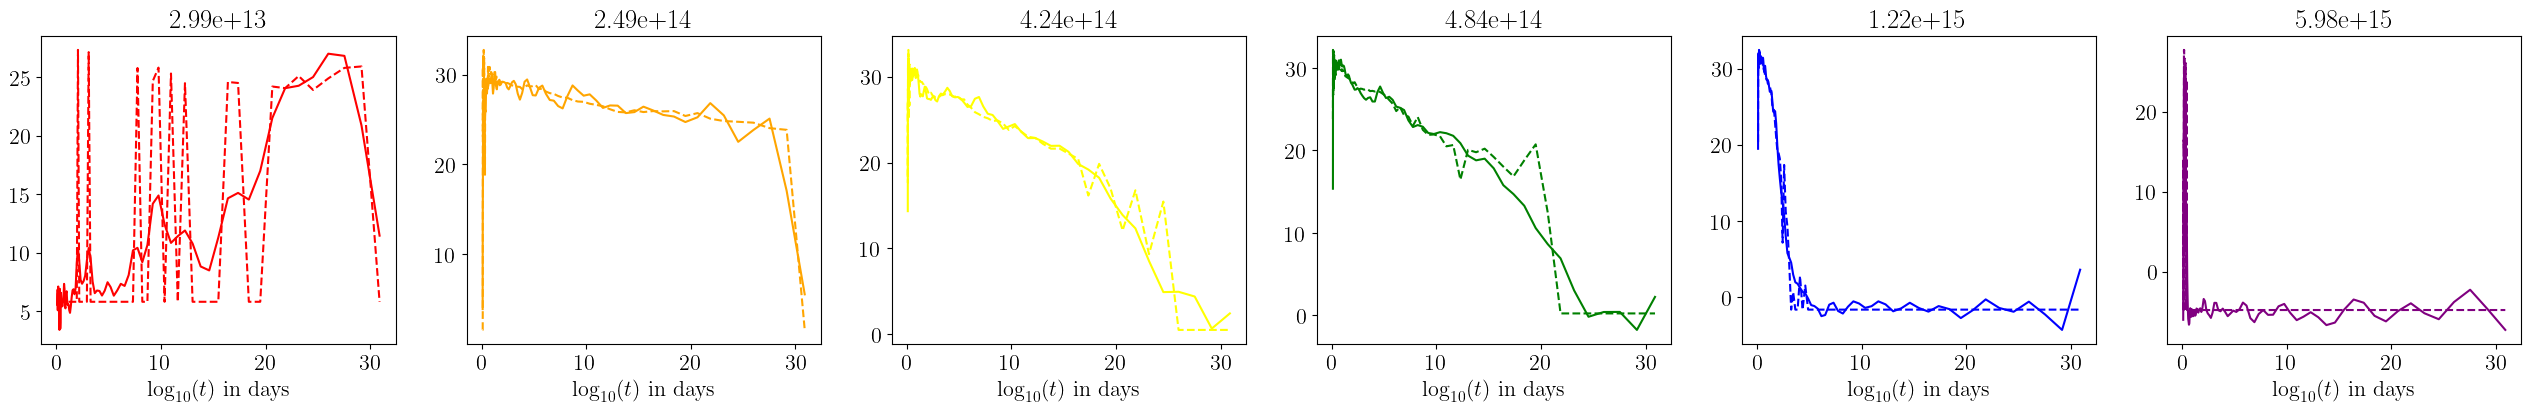

In [62]:
fig, ax = plt.subplots(1,6, figsize = (32,4))

for cax, ind, color in zip(ax, [0, 400, 500, 525, 700, -1], ["red", "orange", "yellow", "green", "blue", "purple"]):
    cax.plot((times), reconstructed_log_flux[ind], color=color)
    cax.plot((times), log_flux[ind], color=color, linestyle="dashed")
    cax.set_xlabel("$\\log_{10}(t)$ in days")
    cax.set_title(f"{nus[ind]:.2e}")

fig.show()

/tmp/ipykernel_2242/3975709318.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


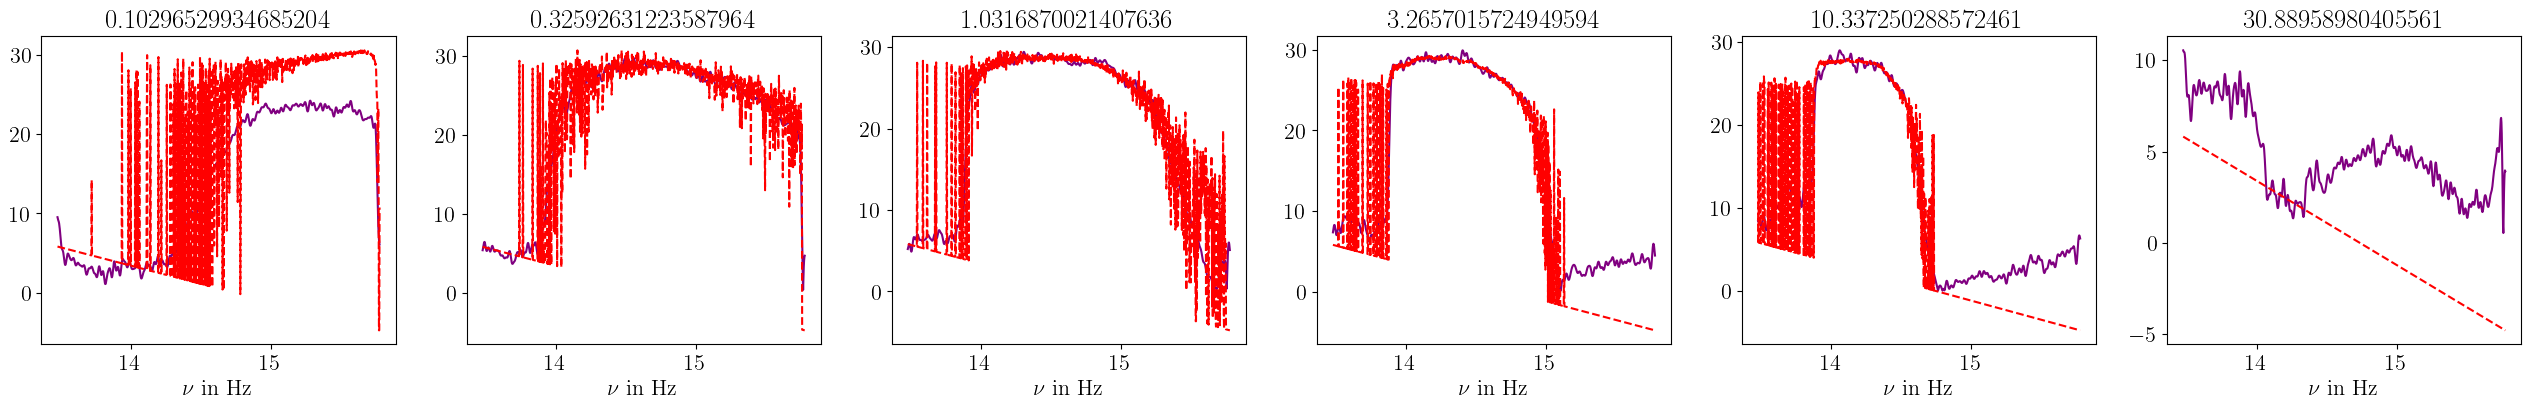

In [35]:
fig, ax = plt.subplots(1,6, figsize = (32,4))

for cax, ind in zip(ax, [0, 20, 40, 60, 80, 99]):
    cax.plot(np.log10(nus), reconstructed_log_flux[:,ind], color="purple")
    cax.plot(np.log10(nus), log_flux[:, ind], color="red", linestyle="dashed")
    cax.set_xlabel("$\\nu$ in Hz")
    cax.set_title(f"{times[ind]}")

fig.show()

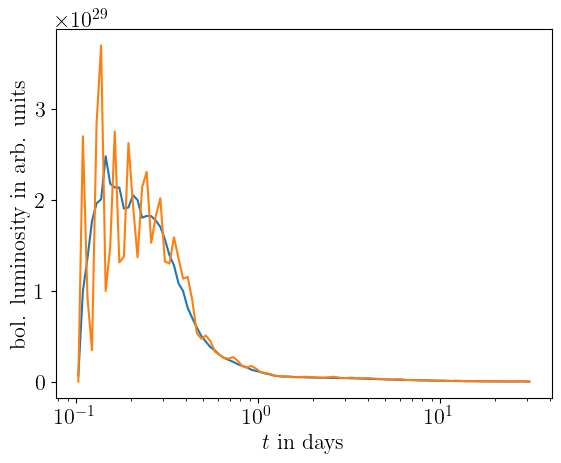

In [26]:
mJys = np.exp(log_flux)
reconstructed_mJys = np.exp(reconstructed_log_flux)

plt.plot(times, np.trapz(x=nus[:], y=mJys[:], axis=0))
plt.plot(times, np.trapz(x=nus[:], y=reconstructed_mJys[:], axis=0))
plt.xlabel("$t$ in days")
plt.ylabel("bol. luminosity in arb. units")
plt.xscale("log")

1.3879087038227227e+29 1.2979282848596916e+29


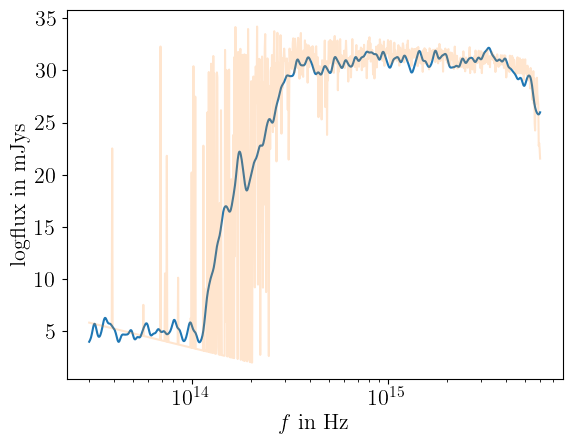

In [27]:
plt.plot(nus, (np.abs(reconstructed_log_flux)[:,10]))
plt.plot(nus, (log_flux[:,10]), alpha=0.2)
plt.xscale('log')
plt.xlabel("$f$ in Hz")
plt.ylabel("logflux in mJys")

print(np.trapz(x=nus[228:], y=np.exp(log_flux[228:,20])), np.trapz(x=nus[228:], y=np.exp(np.abs(reconstructed_log_flux[228:,20]))))

## Process data

In [7]:
def fourier_transform(log_flux, pad_width=20):
    log_flux = log_flux.reshape(1000, 100)

    log_flux_arg = np.pad(log_flux, pad_width=((pad_width, pad_width), (0,0)), mode="edge")
    
    fft_log_flux = np.fft.fftshift(np.fft.fft2(log_flux_arg))
    
    fft_log_flux[:pad_width+400] = 0
    fft_log_flux[-400-pad_width:] = 0
    fft_log_flux[:, :20] = 0
    fft_log_flux[:, -20:] = 0
    
    fft_log_flux[np.abs(fft_log_flux)<4e3] = 0
    
    reconstructed_log_flux = np.fft.ifft2(np.fft.ifftshift(fft_log_flux))
    reconstructed_log_flux = reconstructed_log_flux[pad_width:-pad_width, :]

    return np.abs(reconstructed_log_flux)

#vfourier_transform = np.vectorize(fourier_transform,  excluded=[1])

In [6]:
with h5py.File("./Bu2024_raw_data.h5", "r+") as f:

    for group in ["train", "val", "test"]:
        y_old = f[group]["y"][:]
        y_new = np.maximum(15, y_old)
        f[group]["y"][:] = y_new

In [7]:
with h5py.File("./Bu2024_raw_data.h5", "r") as f:
    test_y_raw = f["test"]["y"][:]

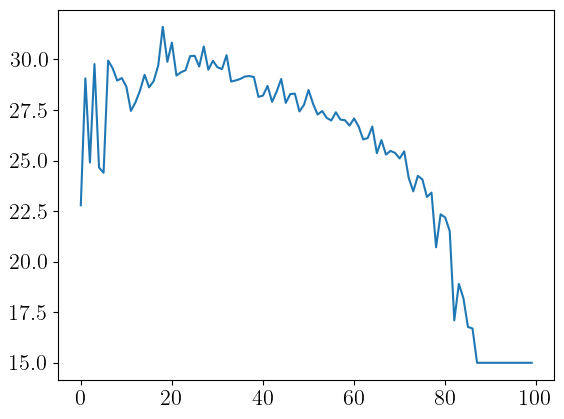

In [10]:
plt.plot(test_y_raw[0].reshape(1000, 100)[500])